# Week 2: Expense Forecasting


In [7]:
import pandas as pd
from faker import Faker
import numpy as np

fake = Faker()
categories = ['Groceries', 'Dining Out', 'Transport', 'Entertainment', 'Utilities', 'Healthcare']
data = []
for _ in range(10000):  # Larger for time-series
    date = fake.date_between(start_date='-2y', end_date='today')
    cat = np.random.choice(categories)
    amount = np.random.uniform(5, 500) if cat != 'Utilities' else np.random.uniform(50, 300)
    desc = fake.sentence(nb_words=5)
    data.append({'date': date, 'description': desc, 'amount': amount, 'category': cat})
df = pd.DataFrame(data)
# Use relative path from notebooks directory (go up one level to access data/)
df.to_csv('../data/synthetic_expenses.csv', index=False)
print(f"Generated {len(df)} expense records")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

Generated 10000 expense records
Date range: 2024-01-01 to 2025-12-31


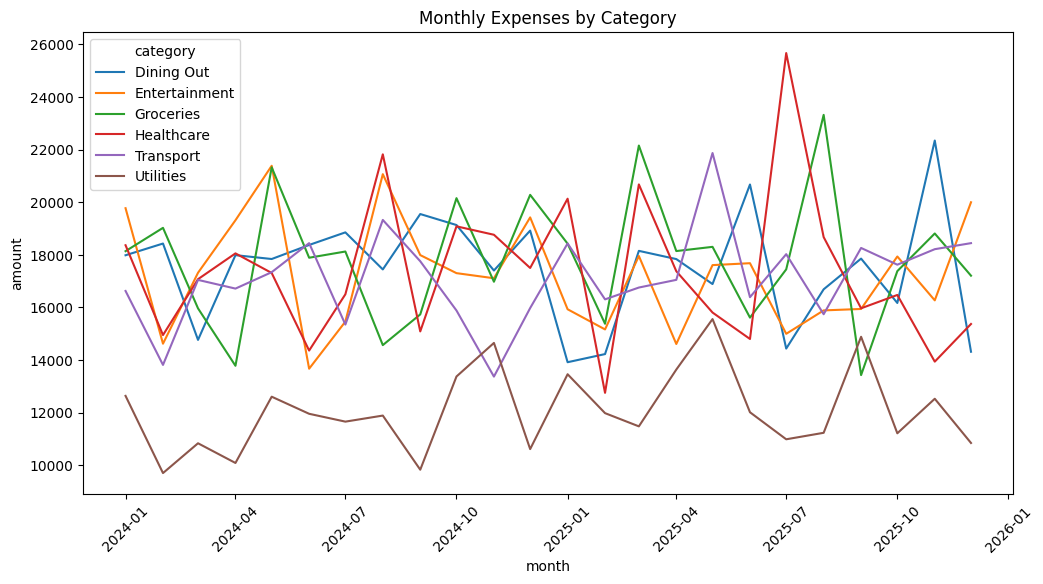

        month    category        amount   prev_amount  prev_2_amount  \
12 2024-03-01  Dining Out  14767.093907  18429.007786   17983.684600   
18 2024-04-01  Dining Out  17987.211960  14767.093907   18429.007786   
24 2024-05-01  Dining Out  17840.840887  17987.211960   14767.093907   
30 2024-06-01  Dining Out  18374.679074  17840.840887   17987.211960   
36 2024-07-01  Dining Out  18853.134770  18374.679074   17840.840887   

    month_num  year  
12          3  2024  
18          4  2024  
24          5  2024  
30          6  2024  
36          7  2024  


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data (from Week 1 or synthetic)
df = pd.read_csv('../data/synthetic_expenses.csv')  # Adjust path

# Preprocess date
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Aggregate: Monthly total per category
df['month'] = df['date'].dt.to_period('M')  # e.g., 2024-01 (use 'M' for Period, not 'ME')
monthly_df = df.groupby(['month', 'category'])['amount'].sum().reset_index()
monthly_df['month'] = monthly_df['month'].dt.to_timestamp()  # For plotting

# Viz aggregates
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_df, x='month', y='amount', hue='category')
plt.title('Monthly Expenses by Category')
plt.xticks(rotation=45)
plt.show()

# Create lagging features (e.g., prev month amount)
monthly_df = monthly_df.sort_values(['category', 'month'])
monthly_df['prev_amount'] = monthly_df.groupby('category')['amount'].shift(1)  # Lag-1
monthly_df['prev_2_amount'] = monthly_df.groupby('category')['amount'].shift(2)  # Lag-2
monthly_df.dropna(inplace=True)  # Drop rows with NaN lags

# Other features: Month number (seasonality)
monthly_df['month_num'] = monthly_df['month'].dt.month
monthly_df['year'] = monthly_df['month'].dt.year  # If multi-year

print(monthly_df.head())

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# IMPORTANT: Sort chronologically for TimeSeriesSplit to work correctly
# (Currently sorted by category, then month - need pure chronological order)
monthly_df = monthly_df.sort_values('month').reset_index(drop=True)

# Features and target (for all categories)
# Keep month and category for later visualization, but don't use month as a feature
X = monthly_df.drop(['amount', 'month'], axis=1).copy()  # Drop target and date
y = monthly_df['amount'].copy()

# Store month and category for later use (reset index to ensure alignment)
month_category_info = monthly_df[['month', 'category']].copy()

# Categorical and numerical
cat_features = ['category']
num_features = ['prev_amount', 'prev_2_amount', 'month_num', 'year']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ])

# Chronological split: Last 20% as test (simulates future)
split_idx = int(len(monthly_df) * 0.8)
X_train = X.iloc[:split_idx].copy()
X_test = X.iloc[split_idx:].copy()
y_train = y.iloc[:split_idx].copy()
y_test = y.iloc[split_idx:].copy()

# Store test set metadata for visualization
test_metadata = month_category_info.iloc[split_idx:].copy().reset_index(drop=True)

In [12]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

# Pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))  # Try LinearRegression() or Lasso(alpha=0.1)
])

# Train
model_pipeline.fit(X_train, y_train)

# Predict
y_pred = model_pipeline.predict(X_test)

RMSE: 2372.32, MAE: 1915.41, R²: 0.31
CV RMSE Mean: 2630.07


TypeError: functools.partial(<class 'matplotlib.lines.Line2D'>, xdata=[], ydata=[]) got multiple values for keyword argument 'label'

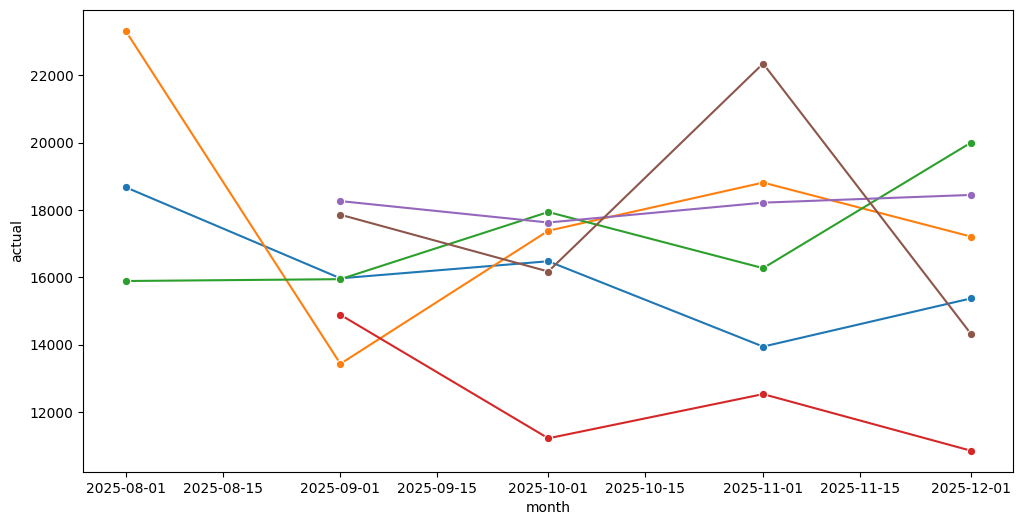

In [17]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
# In scikit-learn 1.8.0+, use root_mean_squared_error instead of mean_squared_error with squared=False
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}')

# Time-series CV (data must be in chronological order)
# Ensure X and y are aligned and sorted chronologically
tscv = TimeSeriesSplit(n_splits=5)
try:
    cv_scores = cross_val_score(model_pipeline, X, y, cv=tscv, scoring='neg_mean_squared_error')
    print(f'CV RMSE Mean: {(-cv_scores.mean())**0.5:.2f}')
except Exception as e:
    print(f"CV Error: {e}")
    print("Note: Ensure data is sorted chronologically for TimeSeriesSplit")

# Viz predictions - use the stored metadata
test_df = test_metadata.copy()
test_df['actual'] = y_test.reset_index(drop=True).values
test_df['predicted'] = y_pred

plt.figure(figsize=(12,6))
# Plot actual values with markers
sns.lineplot(data=test_df, x='month', y='actual', hue='category', marker='o', markersize=6, label='Actual')
# Plot predicted values with dashed lines
sns.lineplot(data=test_df, x='month', y='predicted', hue='category', linestyle='--', label='Predicted')
plt.title('Actual vs Predicted Monthly Expenses')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()